# Customer Segmentation for Financial Services

## Objective
Segment customers into distinct groups based on their financial behavior to improve marketing strategies and service personalization.

## Dataset Overview
The dataset contains customer financial data such as income, spending score, and other demographic features.

## Workflow
1. Load and explore the dataset
2. Preprocess the data
3. Perform EDA to understand clusters
4. Apply clustering algorithms (e.g., K-Means)
5. Visualize clusters
6. Interpret the segments

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["axes.labelsize"] = 11

In [2]:
df = pd.read_csv(r"C:\Users\hp\Downloads\Finance Work\customer_segment_data.csv")
print("Shape:", df.shape)
df.head()

Shape: (1000, 5)


,Customer_Age,Annual_Income,Credit_Score,Loan_Amount,Investment
0,56,125186,414,8239,6439
1,69,54674,622,7710,47964
2,46,55854,339,22384,48062
3,32,66271,339,22038,35563
4,60,93688,588,41846,34964


In [3]:
df.describe()

,Customer_Age,Annual_Income,Credit_Score,Loan_Amount,Investment
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,43.81900,84905.976000,574.918000,24606.387000,25305.027000
std,14.99103,38430.889006,158.037733,14085.866577,14104.112905
min,18.00000,20060.000000,300.000000,1138.000000,582.000000
25%,31.00000,51945.500000,440.000000,12387.750000,13297.500000
50%,44.00000,84699.000000,578.000000,23753.000000,25548.000000
75%,56.00000,117858.000000,707.000000,36426.500000,37103.250000
max,69.00000,149972.000000,849.000000,49980.000000,49930.000000


## EDA: distributions and relationships

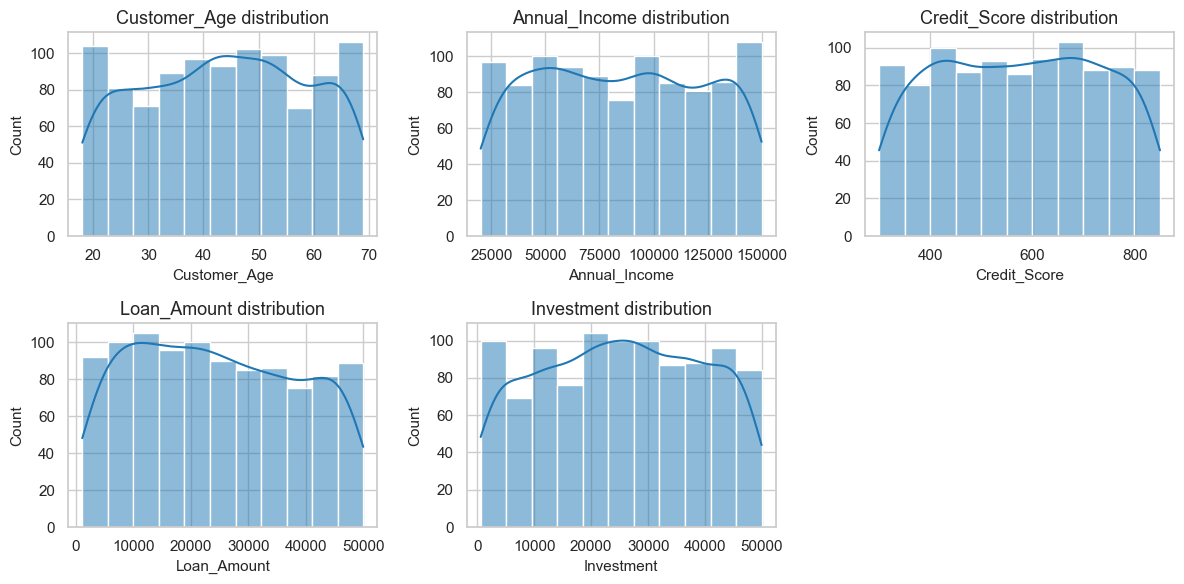

In [4]:
# Histograms
num_cols = ["Customer_Age", "Annual_Income", "Credit_Score", "Loan_Amount", "Investment"]

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color="tab:blue")
    axes[i].set_title(f"{col} distribution")

fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

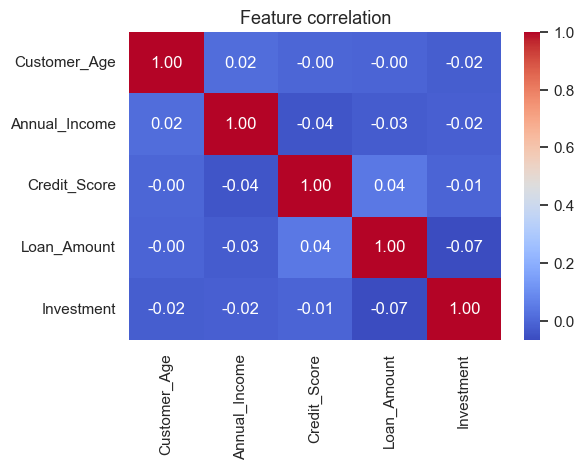

In [5]:
# Correlation heatmap
plt.figure(figsize=(6, 4))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature correlation")
plt.show()

## Preprocessing and scaling

In [6]:
X = df[num_cols].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled shape:", X_scaled.shape)

Scaled shape: (1000, 5)


## Find optimal k (elbow + silhouette)

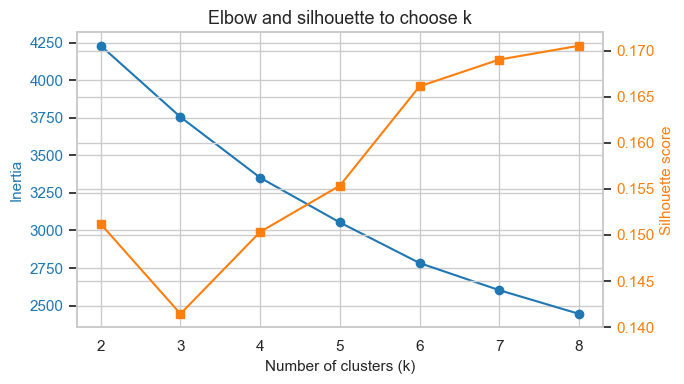

In [7]:
from sklearn.metrics import silhouette_score

inertias = []
sil_scores = []
k_range = range(2, 9)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

fig, ax1 = plt.subplots()

color1 = "tab:blue"
ax1.plot(k_range, inertias, marker="o", color=color1)
ax1.set_xlabel("Number of clusters (k)")
ax1.set_ylabel("Inertia", color=color1)
ax1.tick_params(axis="y", labelcolor=color1)
ax1.set_title("Elbow and silhouette to choose k")

ax2 = ax1.twinx()
color2 = "tab:orange"
ax2.plot(k_range, sil_scores, marker="s", color=color2)
ax2.set_ylabel("Silhouette score", color=color2)
ax2.tick_params(axis="y", labelcolor=color2)

plt.tight_layout()
plt.show()

## Final K‑Means model and basic profiles

In [8]:
best_k = 4  # set based on elbow/silhouette

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

df["Cluster"] = cluster_labels
df["Cluster"] = df["Cluster"].astype(int)

df["Cluster"].value_counts().sort_index()

Cluster
0    248
1    243
2    252
3    257
Name: count, dtype: int64

In [9]:
# Cluster-wise feature means (segment profiles)
cluster_profile = df.groupby("Cluster")[num_cols].mean().round(1)
cluster_profile

,Customer_Age,Annual_Income,Credit_Score,Loan_Amount,Investment
Cluster,,,,,
0,41.8,123980.1,583.3,28623.0,14965.5
1,55.8,56306.1,654.6,30757.2,22199.4
2,50.4,100006.1,478.9,15286.4,35089.4
3,28.1,59435.8,585.7,24053.3,28624.9


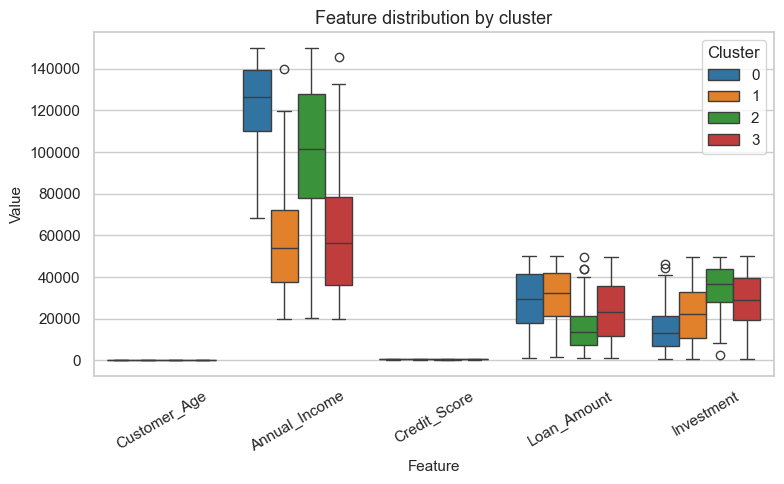

In [10]:
plt.figure(figsize=(8, 5))
melted = df.melt(id_vars="Cluster", value_vars=num_cols,
                 var_name="Feature", value_name="Value")

sns.boxplot(
    data=melted,
    x="Feature",
    y="Value",
    hue="Cluster",
    palette="tab10"
)
plt.xticks(rotation=30)
plt.title("Feature distribution by cluster")
plt.tight_layout()
plt.show()

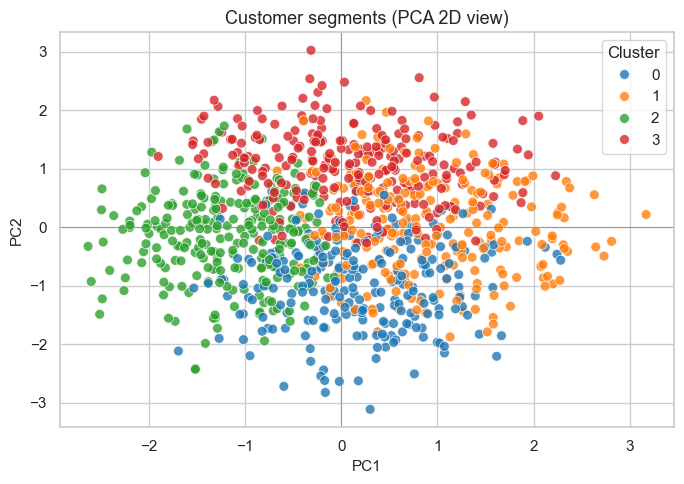

Explained variance by PC1 & PC2: [0.218 0.21 ]


In [11]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["Cluster"] = df["Cluster"]

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue="Cluster",
    palette="tab10",
    s=50,
    alpha=0.8
)
plt.title("Customer segments (PCA 2D view)")
plt.axhline(0, color="grey", linewidth=0.5)
plt.axvline(0, color="grey", linewidth=0.5)
plt.tight_layout()
plt.show()

print("Explained variance by PC1 & PC2:",
      np.round(pca.explained_variance_ratio_, 3))

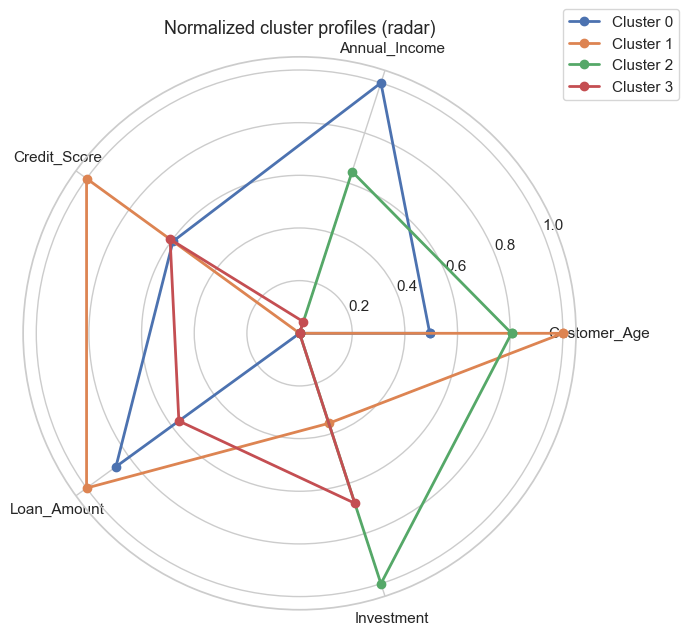

In [12]:
# Normalize cluster profile 0–1 for radar
from sklearn.preprocessing import MinMaxScaler

profile_norm = MinMaxScaler().fit_transform(cluster_profile)
profile_norm = pd.DataFrame(profile_norm, columns=num_cols, index=cluster_profile.index)

labels = num_cols
n_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, n_vars, endpoint=False).tolist()
angles += angles[:1]  # close the polygon

plt.figure(figsize=(7, 7))
for cluster in profile_norm.index:
    values = profile_norm.loc[cluster].tolist()
    values += values[:1]
    plt.polar(angles, values, marker="o", label=f"Cluster {cluster}", linewidth=2)

plt.xticks(angles[:-1], labels)
plt.title("Normalized cluster profiles (radar)")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()

## Conclusion
- Customers were segmented using KMeans clustering.
- PCA helped in visualizing distinct groups.
- These segments can help tailor financial products and marketing strategies.